In [1]:
# Karkovnyk Artem. KI-191

In [2]:
import sys
sys.setrecursionlimit(100000000)

In [3]:
import cv2
from matplotlib.pyplot import imshow, figure
import numpy as np
from copy import copy

In [4]:
VIDEONAME = 'SlowMotionDogRun.webm'
background = cv2.imread('background.jpg')

In [5]:
def read_frame(cap):
    flag, frame = cap.read()
    return frame
    
def frame_to_grayscale(frame):
    return frame.sum(axis=2) / 3

def get_dx(frame):
    tmp = np.zeros([frame.shape[0], frame.shape[1]+1])
    tmp[:, 1:] = frame
    dx = tmp[:, 1:] - tmp[:, :-1]
    return np.abs(dx)

def get_dy(frame):
    tmp = np.zeros([frame.shape[0]+1, frame.shape[1]])
    tmp[1:, :] = frame
    dy = tmp[1:, :] - tmp[:-1, :]
    return np.abs(dy)

def get_diff(frame1, frame2):
    return np.abs(frame2 - frame1)

def get_conture_image(dx1, dx2, dy1, dy2, diff):
    return np.abs(dx1) + np.abs(dy1)  +  diff + np.abs(dx2) + np.abs(dy2) 

def blur(image_input):
    image = copy(image_input)
    tmp = np.zeros([image.shape[0] + 4, image.shape[1] + 4])
    tmp[2:-2, 2:-2] = image
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            mean = tmp[y:y+4 , x:x+4].mean()
            image[y][x] = mean
    return image

def get_blurred_mask(image):
    tmp = copy(image)
    tmp = (tmp > 40)
    tmp = blur(tmp)
    tmp = blur(tmp)
    tmp = tmp.astype(int)
    return tmp

def get_contures(r):
    img = copy(r)
    def get_conture(x, y):
        conture = set()
        if img[y][x] == 1:
            img[y][x] = 0
            conture.add((x, y))
            if x > 0:
                if y > 0:
                    conture = conture.union(get_conture(x-1, y-1))
                if y < img.shape[0] - 1:
                    conture = conture.union(get_conture(x-1, y+1))
            if x < img.shape[1] - 1:
                if y > 0:
                    conture = conture.union(get_conture(x+1, y-1))
                if y < img.shape[0] - 1:
                    conture = conture.union(get_conture(x+1, y+1))
        return conture
    
    contures = list()
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            cont = get_conture(x, y)
            if len(cont) != 0:
                contures.append(cont)
    return contures

def square_contures_clean(image, contures, square):
    tmp = copy(image)
    for c in contures:
        if len(c) <= 1500:
            for p in c:
                x, y = p
                tmp[y][x] = 0
    return tmp

def combine_dog_color_and_mask(color, mask, grayimg):
    unitedmask = ((mask + (grayimg < color).astype(int)) > 0).astype(int)
    return unitedmask

def cut_borders(image, top, right):
    image[:top, :] = 0
    image[:, :right] = 0
    
def pipeline(gray1, gray2, frame1, dx1, dy1):
    dx2 = get_dx(gray2)
    dy2 = get_dy(gray2)
    diff = get_diff(gray1, gray2)
    cont_image = get_conture_image(dx1, dx2, dy1, dy2, diff)
    cut_borders(cont_image, 90, 130)
    mask = get_blurred_mask(cont_image)
    contures = get_contures(mask)
    mask = square_contures_clean(mask, contures, 1500)
    mask = combine_dog_color_and_mask(65, mask, gray1)
    cut_borders(mask, 90, 130)
    imshow(mask)
    return mask, dx2, dy2
    
def unite(mask, image, background):
    mask_ = mask.reshape([mask.shape[0], mask.shape[1], 1])
    mask1 = np.abs(mask_ - 1)
    return mask_ * image + mask1 * background

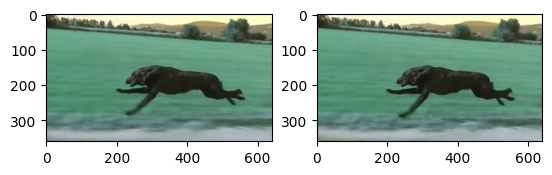

In [6]:
cap = cv2.VideoCapture(VIDEONAME)
for i in range(40):
    cap.read()
frame1 = read_frame(cap)
frame2 = read_frame(cap)
fig = figure()
im1 = fig.add_subplot(1, 2, 1)
im2 = fig.add_subplot(1, 2, 2)
im1.imshow(frame1)
im2.imshow(frame2)

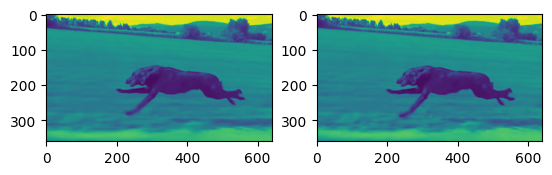

In [7]:
fig = figure()
gray1 = frame_to_grayscale(frame1)
gray2 = frame_to_grayscale(frame2)
im1 = fig.add_subplot(1, 2, 1)
im2 = fig.add_subplot(1, 2, 2)
im1.imshow(gray1)
im2.imshow(gray2)

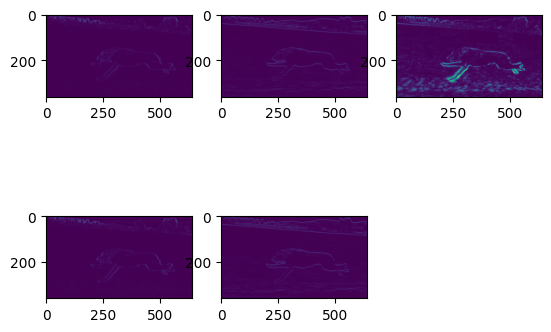

In [8]:
dx1 = get_dx(gray1)
dy1 = get_dy(gray1)
dx2 = get_dx(gray2)
dy2 = get_dy(gray2)
diff = get_diff(gray1, gray2)
fig = figure()
im1 = fig.add_subplot(2, 3, 1)
im2 = fig.add_subplot(2, 3, 2)
im3 = fig.add_subplot(2, 3, 3)
im4 = fig.add_subplot(2, 3, 4)
im5 = fig.add_subplot(2, 3, 5)
im1.imshow(dx1)
im2.imshow(dy1)
im3.imshow(diff)
im4.imshow(dx2)
im5.imshow(dy2)

(360, 640)


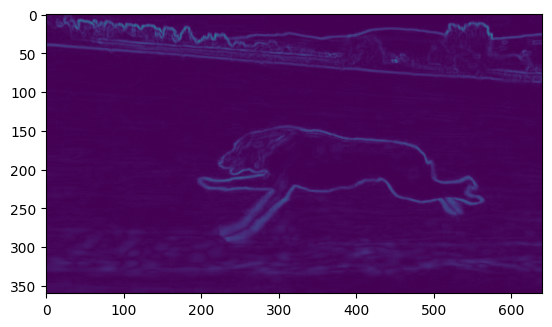

In [9]:
cont_image = get_conture_image(dx1, dx2, dy1, dy2, diff)
imshow(cont_image)
print(cont_image.shape)

(360, 640)


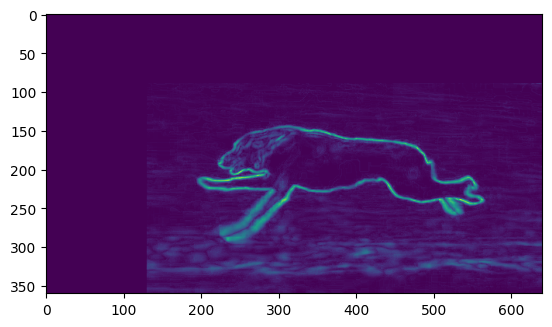

In [10]:
cut_borders(cont_image, 90, 130)
imshow(cont_image)
print(cont_image.shape)

(360, 640)


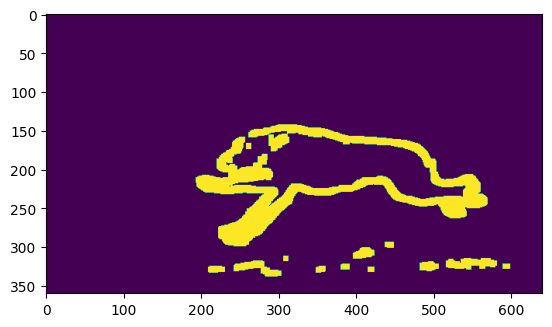

In [11]:
mask = get_blurred_mask(cont_image)
imshow(mask)
print(mask.shape)

(360, 640)


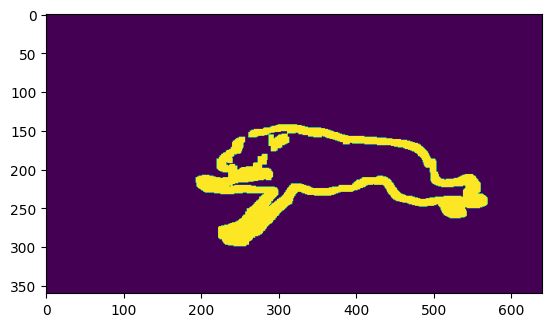

In [12]:
contures = get_contures(mask)
mask = square_contures_clean(mask, contures, 1500)
imshow(mask)
print(cont_image.shape)

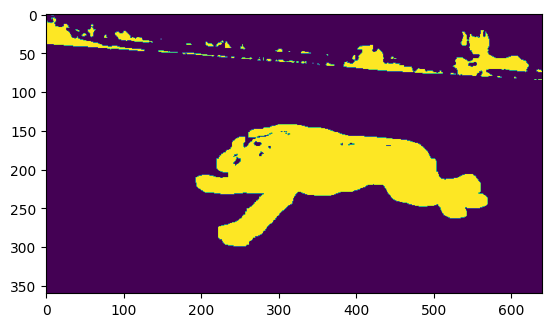

In [13]:
mask = combine_dog_color_and_mask(65, mask, gray1)
imshow(mask)

(360, 640)


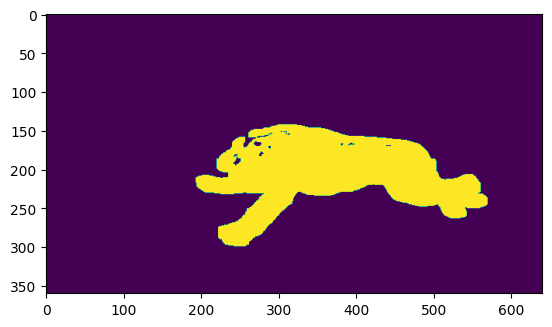

In [14]:
cut_borders(mask, 90, 130)
imshow(mask)
print(mask.shape)

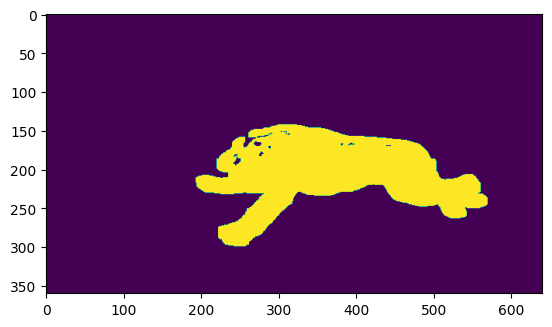

In [15]:
# frame1 = read_frame(cap)
# frame2 = read_frame(cap)

gray1 = frame_to_grayscale(frame1)
gray2 = frame_to_grayscale(frame2)

dx1 = get_dx(gray1)
dy1 = get_dy(gray1)

dx2 = get_dx(gray2)
dy2 = get_dy(gray2)
diff = get_diff(gray1, gray2)
cont_image = get_conture_image(dx1, dx2, dy1, dy2, diff)
cut_borders(cont_image, 90, 130)
mask = get_blurred_mask(cont_image)
contures = get_contures(mask)
mask = square_contures_clean(mask, contures, 1500)
mask = combine_dog_color_and_mask(65, mask, gray1)
cut_borders(mask, 90, 130)
imshow(mask)


In [16]:
result = unite(mask, frame1, background)

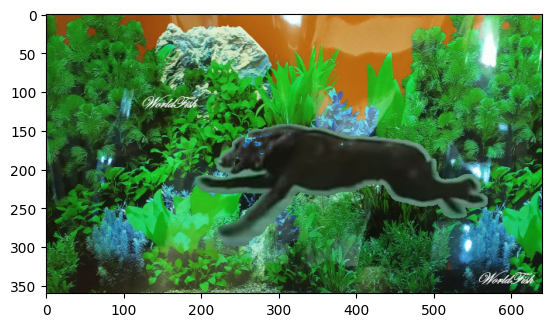

In [17]:
imshow(result)

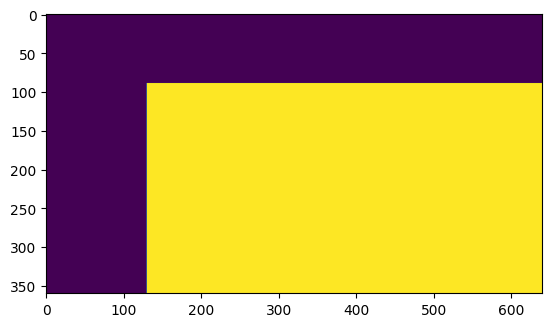

In [18]:
cap = cv2.VideoCapture(VIDEONAME)
for i in range(25):
    cap.read()
out = cv2.VideoWriter("output.avi", cv2.VideoWriter_fourcc(*"MJPG"), 20,(640, 720))

video_is_going, frame1 = cap.read()
gray1 = frame_to_grayscale(frame1)

while True:
    video_is_going, frame2 = cap.read()
    if video_is_going != True:
        break
    gray2 = frame_to_grayscale(frame2)
    mask, dx1, dx = pipeline(gray1, gray2, frame1, dx1, dy1)
    result = unite(mask, frame1, background)
    gray1 = gray2
    frame1 = frame2
    output_frame = np.append(frame1, result, axis=0)
    out.write(output_frame.astype('uint8'))
    
out.release()

    